# 0. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sktime
import statsmodels

RANDOM_STATE = 42

In [2]:
# Chart style settings
import matplotlib.style as style
style.use({'font.family': 'Monospace', 'font.size': 10, })

In [3]:
# Data folders
from pathlib import Path
raw_data_dir = Path.cwd().parent / "data" / "raw"
raw_data_dir.mkdir(parents=True, exist_ok=True)
processed_data_dir = Path.cwd().parent / "data" / "processed"
processed_data_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Spans for time series charts
def add_event_spans(ax):
    return {
        'covid1': ax.axvspan(pd.Timestamp('2020-03'), pd.Timestamp('2020-05'),
                             color="#4BADFEBF", alpha=0.2, label='1st COVID lock-down'),
        'covid2': ax.axvspan(pd.Timestamp('2020-11'), pd.Timestamp('2020-12'),
                             color="#4BADFE81", alpha=0.2, label='2nd COVID lock-down'),
        'covid3': ax.axvspan(pd.Timestamp('2021-01'), pd.Timestamp('2021-04'),
                             color="#4BADFE4D", alpha=0.2, label='3rd COVID lock-down'),
        'energy': ax.axvspan(pd.Timestamp('2021-10'), pd.Timestamp('2022-10'),
                             color="#4B8AFEBE", alpha=0.2, label='Energy-price crisis')
    }

In [5]:
HORIZON = 12

In [6]:
from __future__ import annotations
# from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error, mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss


def evaluate_forecast(
    y_true: pd.Series,
    y_pred: pd.DataFrame,               # columns = quantiles (floats)
    y_train: pd.Series | None = None,
    alpha: float = 0.1,  # for quantiles
    seasonal_period: int = 12,
    break_points: dict[str, pd.Series] | None = None,
) -> dict[str, float]:
    """
    Fast unified evaluation – point + probabilistic metrics.

    Parameters
    ----------
    y_true   : ground-truth Series (timestamp index)
    y_pred   : quantile forecast with columns 0.1, 0.5, 0.9 (or wider)
    y_train  : needed only for MASE
    seasonal_period : seasonality length for MASE
    break_points    : optional dict {name : boolean mask}

    Returns
    -------
    dict  – all scalar metrics
    """
    # --- point forecasts ----------------------------------------------------
    y_med = y_pred[0.5]
    mae = mean_absolute_error(y_true, y_med)
    mse = mean_squared_error(y_true, y_med)
    rmse = mse ** 0.5
    out = {"mae": mae, "mse": mse, "rmse": rmse}

    if y_train is not None:
        out["mase"] = mean_absolute_scaled_error(
            y_true, y_med, y_train=y_train, sp=seasonal_period
        )

    # --- probabilistic metrics (vectorised) ---------------------------------
    pinball = PinballLoss()

    def _quant_df(ser: pd.Series, alpha: float) -> pd.DataFrame:
        """Turn quantile Series into sktime-legal single-column DataFrame."""
        return ser.to_frame().T.set_index([[pd.Index(['target'], name='variable')], [pd.Index([alpha], name='alpha')]]).T

    out['pinball_0.1'] = float(pinball(y_true, _quant_df(y_pred[0.1], 0.1)))
    out['pinball_0.9'] = float(pinball(y_true, _quant_df(y_pred[0.9], 0.9)))

    out["coverage_80"] = ((y_true >= y_pred[0.1]) & (y_true <= y_pred[0.9])).mean()
    out["mean_interval_width"] = float((y_pred[0.9] - y_pred[0.1]).mean())

    # --- regime-specific (if requested) -------------------------------------
    if break_points:
        for tag, mask in break_points.items():
            y_t = y_true.loc[mask]
            y_m = y_med.loc[mask]
            out[f"mae_{tag}"] = mean_absolute_error(y_t, y_m)
            out[f"coverage_80_{tag}"] = (
                (y_t >= y_pred.loc[mask, 0.1]) & (y_t <= y_pred.loc[mask, 0.9])
            ).mean()

    return out

# 1. TabPFN

### Client setup

In [7]:
import tabpfn_client
import dotenv

dotenv.load_dotenv()
token = dotenv.get_key(dotenv.find_dotenv(), "PRIORLABS_API_KEY")
tabpfn_client.set_access_token(token)

## Prediction 1 - "vanilla"

### Load

In [ ]:
from tabpfn_time_series.plot import plot_actual_ts
from autogluon.timeseries import TimeSeriesDataFrame

data_path = processed_data_dir / "model_data.pkl"
meta_path = processed_data_dir / "meta_data.pkl"

df = pd.read_pickle(data_path)
df_reset = df.reset_index()
df_reset = df_reset.rename(columns={'online_retail_sales_share': 'target'})
df_reset['item_id'] = 'retail_series'

# Temporal and time-based features
df_full = df_reset.copy()
df_full["month"] = df_full["date"].dt.month
df_full["day_of_year"] = df_full["date"].dt.dayofyear
df_full["week_of_year"] = df_full["date"].dt.isocalendar().week.astype("int")
df_full["quarter"] = df_full["date"].dt.quarter

# Lag / rolling features (properly shifted to avoid leakage)
for lag in [1, 2, 6, 12]:
    df_full[f"lag_{lag}"] = df_full.groupby("item_id")["target"].shift(lag)

for w in [7, 14, 30]:
    df_full[f"roll_mean_{w}"] = (
        df_full.groupby("item_id")["target"]
               .shift(1)                       # shift=1  =>  no leakage
               .rolling(window=w, min_periods=1).mean()
    )

# Shift exogenous variables to avoid leakage
calendar_cols = ["month", "day_of_year", "week_of_year", "quarter"]
never_shift = ["target", "date", "item_id"] + calendar_cols
to_shift = [c for c in df_full.columns if c not in never_shift]
df_full[to_shift] = df_full.groupby("item_id")[to_shift].shift(1)

# Remove rows with missing target values
df_full = df_full.dropna(subset=["target"])

tsdf = TimeSeriesDataFrame.from_data_frame(
    df_full,
    id_column="item_id",
    timestamp_column="date",
    static_features_df=None
)

train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(prediction_length=HORIZON)
test_tsdf = test_tsdf_ground_truth[-HORIZON:].copy()
test_tsdf['target'] = np.nan

print(f"Training data shape: {train_tsdf.shape}")
print(f"Groundtruth data shape: {test_tsdf_ground_truth.shape}")
print(f"Test data shape: {test_tsdf.shape}")
print(f"Prediction length: {HORIZON}")

plot_actual_ts(train_tsdf, test_tsdf_ground_truth)

### Prediction

In [ ]:
from tabpfn_time_series.plot import plot_pred_and_actual_ts
from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode

predictor = TabPFNTimeSeriesPredictor(tabpfn_mode=TabPFNMode.CLIENT)
pred = predictor.predict(train_tsdf, test_tsdf)

test_future_tsdf = test_tsdf_ground_truth.groupby('item_id').tail(n=HORIZON)
pred_future_tsdf = pred
train_future_tsdf = train_tsdf

plot_pred_and_actual_ts(
    pred=pred_future_tsdf,
    train=train_future_tsdf,
    test=test_future_tsdf,
    item_ids=['retail_series'],
    show_points=False,
)

### Better plot

In [69]:
# Data prep
train_df = (train_tsdf.loc['retail_series'].reset_index().assign(series='train').rename(columns={'target': 'value'}))
actual_df = (test_tsdf_ground_truth.groupby('item_id').tail(12).loc['retail_series'].reset_index().assign(series='actual').rename(columns={'target': 'value'}))

# median forecast
med_df = (pred.loc['retail_series', 0.5].to_frame('value').reset_index().assign(series='forecast'))

# lower / upper 80 % band
lo_df = (pred.loc['retail_series', 0.1].to_frame('value').reset_index().assign(series='lower80'))
hi_df = (pred.loc['retail_series', 0.9].to_frame('value').reset_index().assign(series='upper80'))

plot_df = pd.concat([train_df, actual_df, med_df, lo_df, hi_df], ignore_index=True)

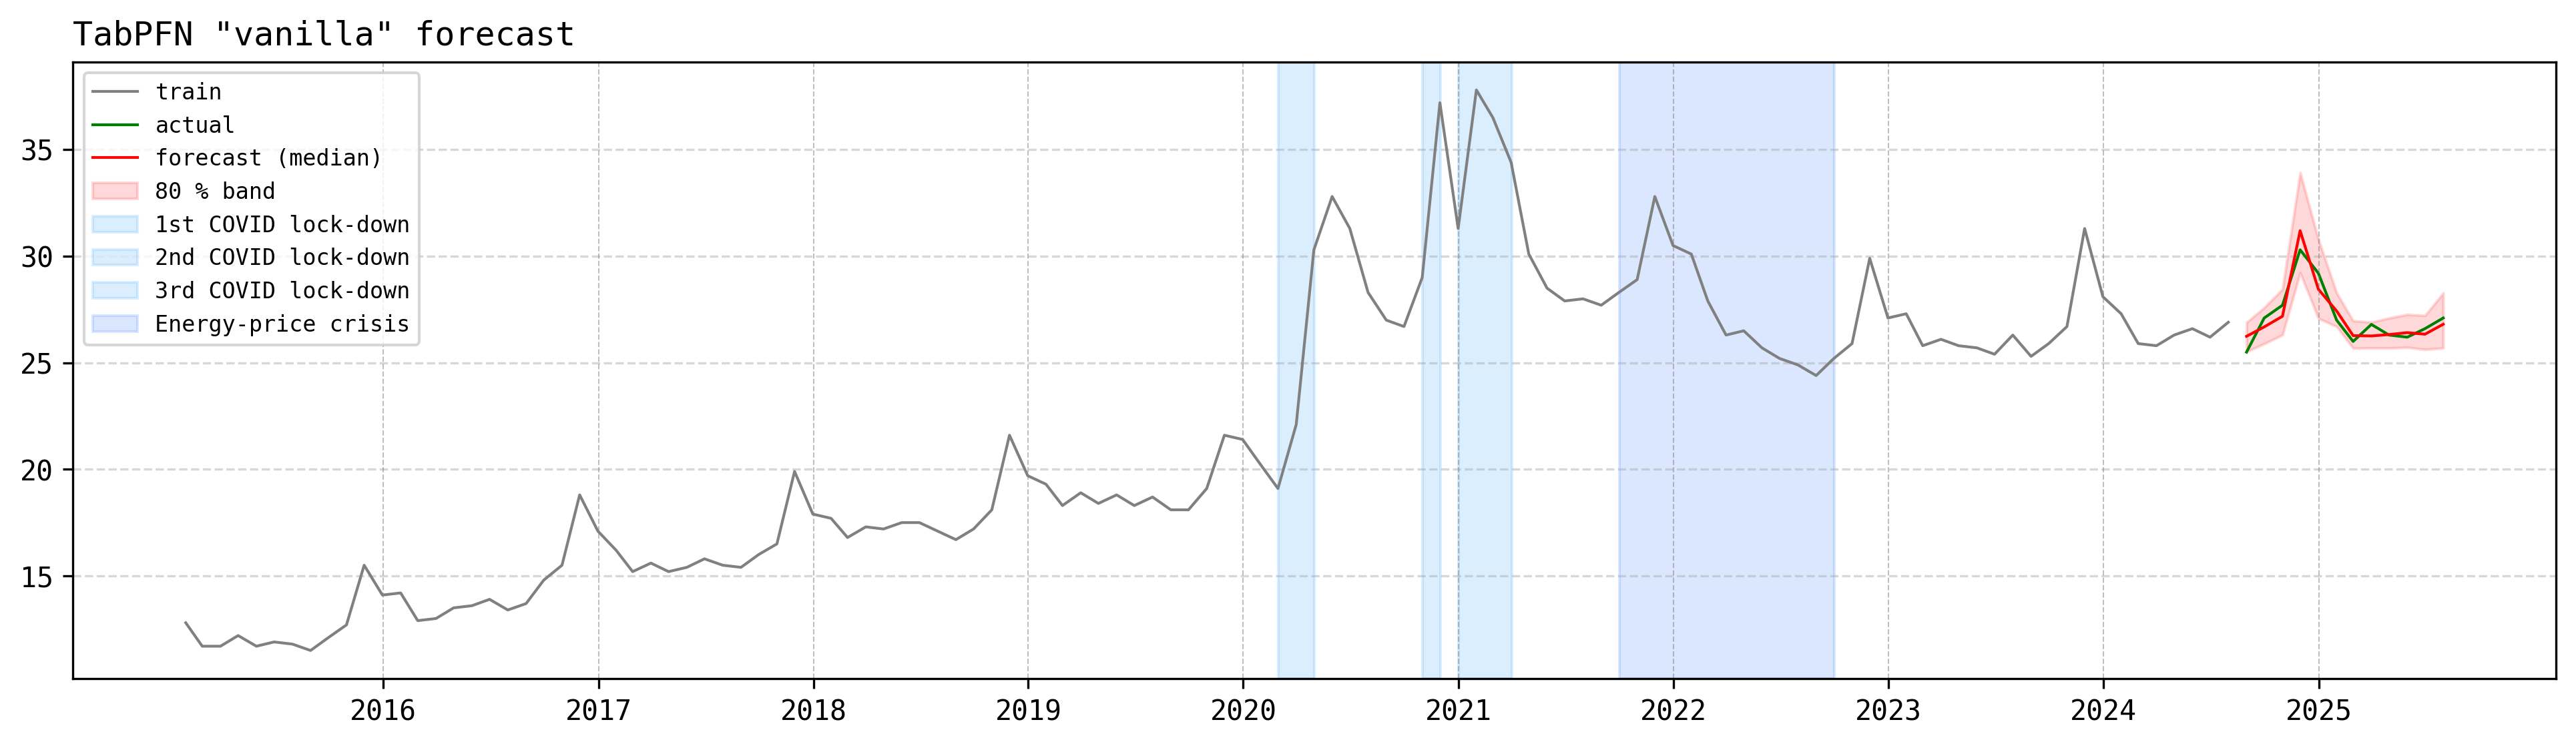

In [79]:
# Plotting
plt.figure(figsize=(16, 4), dpi=300)

sns.lineplot(data=plot_df.query("series == 'train'"), x='timestamp', y='value', linewidth=1, color='grey', label='train')
sns.lineplot(data=plot_df.query("series == 'actual'"), x='timestamp', y='value', linewidth=1, color='green', label='actual')
sns.lineplot(data=plot_df.query("series == 'forecast'"), x='timestamp', y='value', linewidth=1, color='red', label='forecast (median)')

lower = plot_df.query("series == 'lower80'").set_index('timestamp')['value']
upper = plot_df.query("series == 'upper80'").set_index('timestamp')['value']
plt.fill_between(lower.index, lower, upper, color='red', alpha=.15, label='80 % band')

ax = plt.gca()
time_range = pd.date_range(start=plot_df['timestamp'].min(),
                           end=plot_df['timestamp'].max(),
                           freq='YS')  # Year start frequency
ax.set_xticks(time_range)
ax.set_xticklabels([t.year for t in time_range])
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Spans for significant events
event_spans = add_event_spans(ax)

ax.legend(fontsize=8)

plt.xlabel('')
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title('TabPFN "vanilla" forecast', loc='left')
# plt.savefig('../outputs/figures/UK_online_retail_share_trend_with_spans.png', bbox_inches='tight', dpi=300)
plt.show()

## Prediction 2 - "vanilla" with shifted exog features

### Setup

In [ ]:
from tabpfn_time_series.plot import plot_actual_ts
from autogluon.timeseries import TimeSeriesDataFrame

data_path = processed_data_dir / "model_data.pkl"
meta_path = processed_data_dir / "meta_data.pkl"

df = pd.read_pickle(data_path)
df_reset = df.reset_index()
df_reset = df_reset.rename(columns={'online_retail_sales_share': 'target'})
df_reset['item_id'] = 'retail_series'

# Temporal and time-based features
df_full = df_reset.copy()
df_full["month"] = df_full["date"].dt.month
df_full["day_of_year"] = df_full["date"].dt.dayofyear
df_full["week_of_year"] = df_full["date"].dt.isocalendar().week.astype("int")
df_full["quarter"] = df_full["date"].dt.quarter

# Lag / rolling features (properly shifted to avoid leakage)
for lag in [1, 2, 6, 12]:
    df_full[f"lag_{lag}"] = df_full.groupby("item_id")["target"].shift(lag)

for w in [7, 14, 30]:
    df_full[f"roll_mean_{w}"] = (
        df_full.groupby("item_id")["target"]
               .shift(1)          # past-only window
               .rolling(w, min_periods=1).mean()
    )

# Shift exogenous variables to avoid leakage
calendar_cols = ["month", "day_of_year", "week_of_year", "quarter"]
never_shift = ["target", "date", "item_id"] + calendar_cols
to_shift = [c for c in df_full.columns if c not in never_shift]
df_full[to_shift] = df_full.groupby("item_id")[to_shift].shift(1)

# Remove rows with missing target values
df_full = df_full.dropna(subset=["target"])

tsdf = TimeSeriesDataFrame.from_data_frame(
    df_full,
    id_column="item_id",
    timestamp_column="date",
    static_features_df=None
)

train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(prediction_length=HORIZON)
test_tsdf = test_tsdf_ground_truth[-HORIZON:].copy()
test_tsdf['target'] = np.nan

print(f"Training data shape: {train_tsdf.shape}")
print(f"Groundtruth data shape: {test_tsdf_ground_truth.shape}")
print(f"Test data shape: {test_tsdf.shape}")
print(f"Prediction length: {HORIZON}")

# plot_actual_ts(train_tsdf, test_tsdf_ground_truth)

### Fit

In [9]:
from tabpfn_time_series.plot import plot_pred_and_actual_ts
from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode

predictor = TabPFNTimeSeriesPredictor(tabpfn_mode=TabPFNMode.CLIENT)
pred = predictor.predict(train_tsdf, test_tsdf)

test_future_tsdf = test_tsdf_ground_truth.groupby('item_id').tail(n=HORIZON)
pred_future_tsdf = pred
train_future_tsdf = train_tsdf
"""
plot_pred_and_actual_ts(
    pred=pred_future_tsdf,
    train=train_future_tsdf,
    test=test_future_tsdf,
    item_ids=['retail_series'],
    show_points=False,
)"""

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1194.62it/s]
Processing: 100%|██████████| [00:02<00:00]


"\nplot_pred_and_actual_ts(\n    pred=pred_future_tsdf,\n    train=train_future_tsdf,\n    test=test_future_tsdf,\n    item_ids=['retail_series'],\n    show_points=False,\n)"

### Plot

In [11]:
# Data prep
train_df = (train_tsdf.loc['retail_series'].reset_index().assign(series='train').rename(columns={'target': 'value'}))
actual_df = (test_tsdf_ground_truth.groupby('item_id').tail(12).loc['retail_series'].reset_index().assign(series='actual').rename(columns={'target': 'value'}))

# median forecast
med_df = (pred.loc['retail_series', 0.5].to_frame('value').reset_index().assign(series='forecast'))

# lower / upper 80 % band
lo_df = (pred.loc['retail_series', 0.1].to_frame('value').reset_index().assign(series='lower80'))
hi_df = (pred.loc['retail_series', 0.9].to_frame('value').reset_index().assign(series='upper80'))

plot_df = pd.concat([train_df, actual_df, med_df, lo_df, hi_df], ignore_index=True)

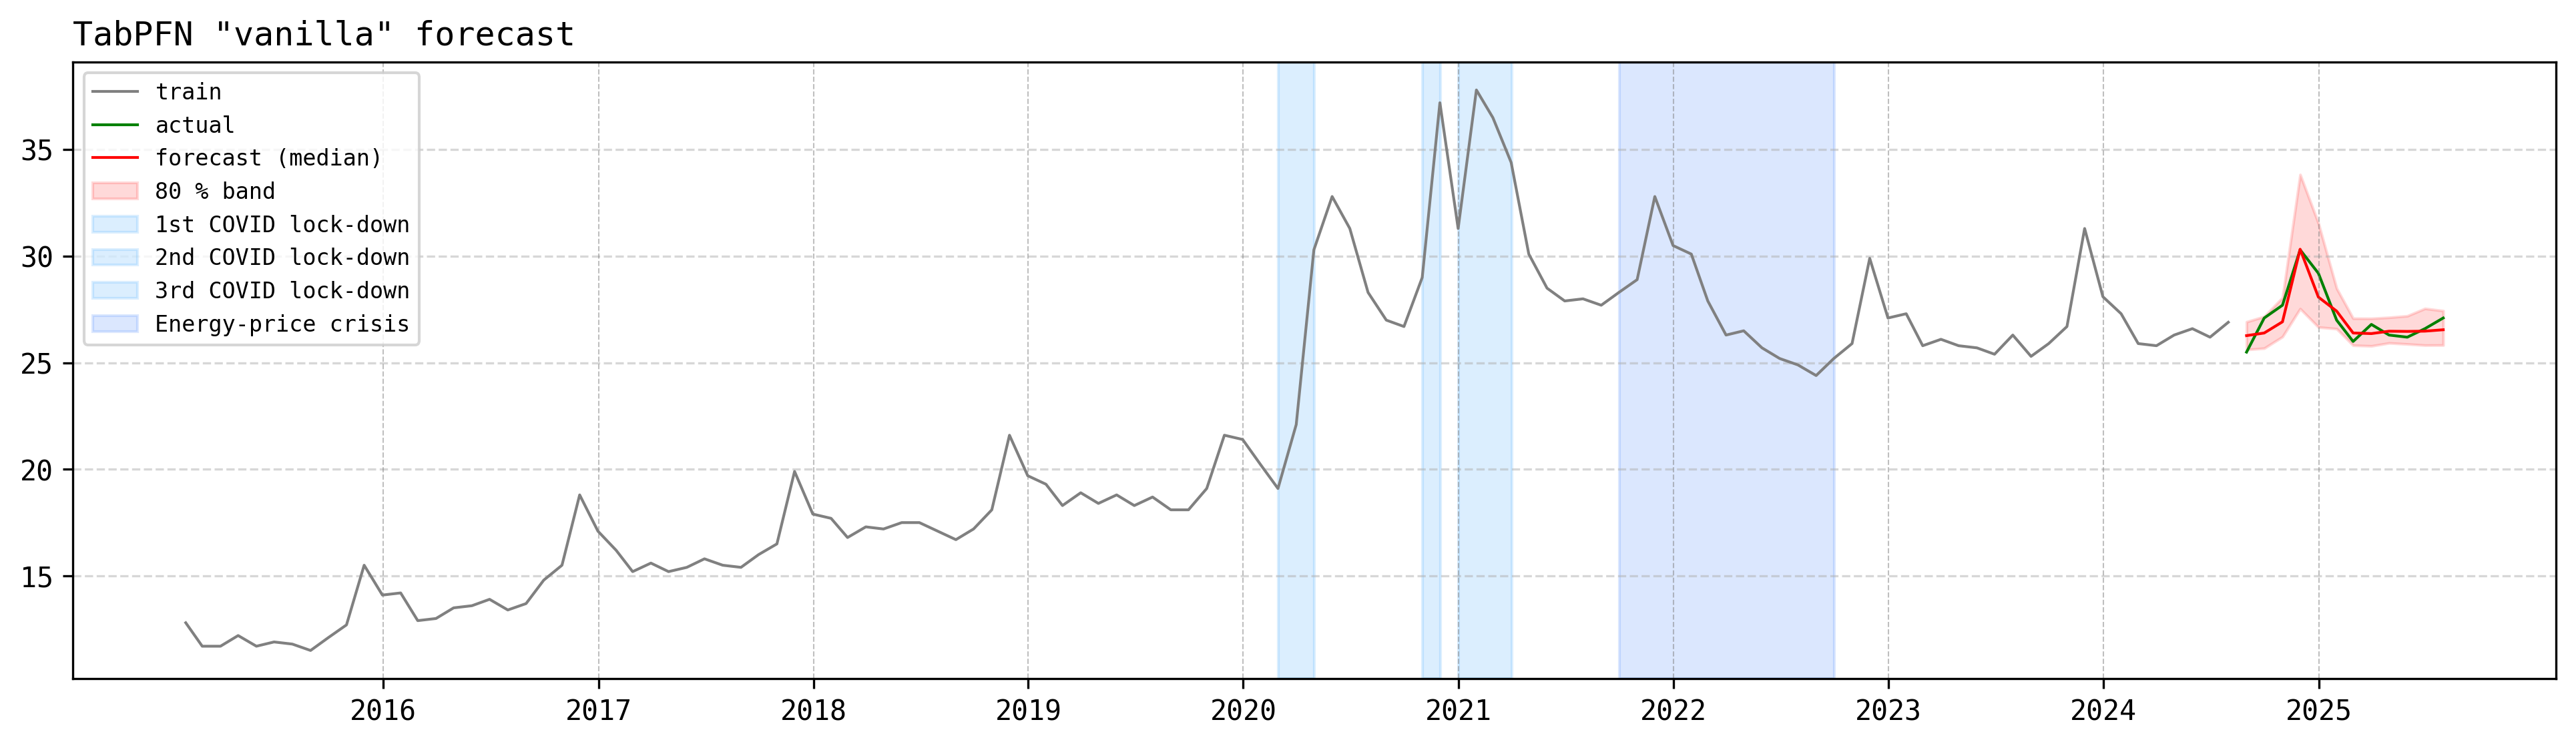

In [12]:
# Plotting
plt.figure(figsize=(16, 4), dpi=300)

sns.lineplot(data=plot_df.query("series == 'train'"), x='timestamp', y='value', linewidth=1, color='grey', label='train')
sns.lineplot(data=plot_df.query("series == 'actual'"), x='timestamp', y='value', linewidth=1, color='green', label='actual')
sns.lineplot(data=plot_df.query("series == 'forecast'"), x='timestamp', y='value', linewidth=1, color='red', label='forecast (median)')

lower = plot_df.query("series == 'lower80'").set_index('timestamp')['value']
upper = plot_df.query("series == 'upper80'").set_index('timestamp')['value']
plt.fill_between(lower.index, lower, upper, color='red', alpha=.15, label='80 % band')

ax = plt.gca()
time_range = pd.date_range(start=plot_df['timestamp'].min(),
                           end=plot_df['timestamp'].max(),
                           freq='YS')  # Year start frequency
ax.set_xticks(time_range)
ax.set_xticklabels([t.year for t in time_range])
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Spans for significant events
event_spans = add_event_spans(ax)

ax.legend(fontsize=8)

plt.xlabel('')
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title('TabPFN "vanilla" forecast', loc='left')
# plt.savefig('../outputs/figures/UK_online_retail_share_trend_with_spans.png', bbox_inches='tight', dpi=300)
plt.show()

### Evaluate

In [13]:
# 1. use the NON-empty frame you already have
# pred_slice = pred_future_tsdf.loc['retail_series']
pred_slice = pred.loc['retail_series']  # 12 rows

lo_df = pred_slice[0.1].to_frame('value')
med_df = pred_slice[0.5].to_frame('value')
hi_df = pred_slice[0.9].to_frame('value')

# 2. certified MultiIndex column frame (variable, alpha)
y_pred = pd.concat(
    {"target": pd.concat({0.1: lo_df["value"],
                          0.5: med_df["value"],
                          0.9: hi_df["value"]}, axis=1)}, axis=1
)

# 3. ground-truth Series (same DatetimeIndex)
y_true = (actual_df
          .set_index("timestamp")["value"]
          .reindex(y_pred.index))          # identical timestamps → no NaNs

# 4. metrics (unchanged)
pinball = PinballLoss()
mae = mean_absolute_error(y_true, y_pred[("target", 0.5)])
pin01 = pinball(y_true, y_pred[[("target", 0.1)]])
pin09 = pinball(y_true, y_pred[[("target", 0.9)]])

cov = ((y_true >= y_pred[("target", 0.1)]) & (y_true <= y_pred[("target", 0.9)])).mean()
width = (y_pred[("target", 0.9)] - y_pred[("target", 0.1)]).mean()

metrics = {
    "mae": float(mae),
    "pinball_0.1": float(pin01),
    "pinball_0.9": float(pin09),
    "coverage_80": float(cov),
    "mean_interval_width": float(width),
}

/home/mikhailarutyunov/projects/time-series-methods/time-series-methods/.venv/lib/python3.12/site-packages/sktime/performance_metrics/forecasting/probabilistic/_classes.py:335: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_pred_inner.sort_index(axis=1, level=[0, 1], inplace=True)
/home/mikhailarutyunov/projects/time-series-methods/time-series-methods/.venv/lib/python3.12/site-packages/sktime/performance_metrics/forecasting/probabilistic/_classes.py:335: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_pred_inner.sort_index(axis=1, level=[0, 1], inplace=True)


In [14]:
metrics

{'mae': 0.48095299402872715,
 'pinball_0.1': 0.11316632270812971,
 'pinball_0.9': 0.11416544278462737,
 'coverage_80': 0.9166666666666666,
 'mean_interval_width': 2.177044232686363}

In [16]:
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
y_train = train_tsdf.loc['retail_series']['target']
mase = mean_absolute_scaled_error(
    y_true, y_pred["target", 0.5],
    y_train=y_train, sp=12
)
mase

0.15656813648849205

### Interpretation

In [22]:
import shapiq
from shapiq import Explainer

In [27]:
background_data = df_full.head(-12).select_dtypes(include=[np.number])
explain_X = df_full.tail(12).select_dtypes(include=[np.number])

explainer = Explainer(
    model=predictor,
    data=background_data.values,  # Convert to NumPy here
    index="SV",
    max_order=1
)

explanation = explainer.explain(explain_X.iloc[0].values,
                                budget=256)
explanation.plot_force()

TypeError:  The model's prediction failed with the following error: TabPFNTimeSeriesPredictor.predict() missing 1 required positional argument: 'test_tsdf'.

In [29]:
from shapiq import TabularExplainer
background_data = df_full.head(-12).select_dtypes(include=[np.number]).values  # Exclude non-numeric columns
explain_X = df_full.tail(12).select_dtypes(include=[np.number]).values

# Ensure 2D array
if background_data.ndim == 1:
    background_data = background_data.reshape(1, -1)
if explain_X.ndim == 1:
    explain_X = explain_X.reshape(1, -1)

explainer = TabularExplainer(
    model=predictor,
    data=background_data,        # NumPy array
    index="SV",                  # Shapley Values
    max_order=1                  # First-order only
)

# Explain first row
explanation = explainer.explain(explain_X[0], budget=256)
explanation.plot_force()

TypeError:  The model's prediction failed with the following error: TabPFNTimeSeriesPredictor.predict() missing 1 required positional argument: 'test_tsdf'.